# 2-D Kuramoto-Sivashinsky with Continuation (Zero Mean)

This notebook simulates the 2-D Kuramoto-Sivashinsky equation, enforcing a zero mean on the solution at each step. A simple numerical continuation is performed by varying the nonlinearity coefficient $\lambda$. For each value of $\lambda$, the system is evolved to a statistically steady state.

The modified Kuramoto-Sivashinsky equation is:
$$
\partial_t u = -\nabla^2 u - \epsilon \nabla^4 u - \frac{\lambda}{2} |\nabla u|^2
$$
on a periodic square domain.

### Parameters:
* $\epsilon$: Coefficient of hyperdiffusion (fixed).
* $\lambda$: Bifurcation parameter (varied through continuation).

In [1]:
import numpy as np
from numpy.fft import fft2, ifft2, fftfreq
import matplotlib.pyplot as plt

np.random.seed(42)
plt.rcParams.update({"figure.figsize": (6, 4), "image.cmap": "inferno"})

### Parameters
Define the physical and numerical parameters for the simulation.

In [2]:
N = 128          # Grid resolution
L = 64.0         # Domain size
dt = 0.05        # Time step
epsilon = 1.0    # Fixed hyperdiffusion coefficient
steps_per_lambda = 2000
lambdas = np.linspace(0.5, 2.5, 21) # Continuation parameter range

### Spatial grid and spectral operators
Set up the computational grid, wavenumbers, and a dealiasing mask for the spectral method.

In [3]:
x = np.linspace(0, L, N, endpoint=False)
X, Y = np.meshgrid(x, x, indexing="ij")

k = 2 * np.pi * fftfreq(N, d=L / N)
KX, KY = np.meshgrid(k, k, indexing="ij")
K2 = KX**2 + KY**2
K4 = K2**2

# Dealiasing mask (2/3 rule)
k_cut = (2.0 / 3.0) * np.max(np.abs(k))
mask = (np.abs(KX) <= k_cut) & (np.abs(KY) <= k_cut)

### Helper functions
`dealiase`: Applies the dealiasing mask in Fourier space.
`l2_norm`: Computes the L2 norm of the solution.
`step`: Performs a single time step using a semi-implicit Euler scheme. Note the line `u_hat_new[0, 0] = 0.0`, which enforces a zero mean.

In [4]:
def dealiase(hat_field):
    return hat_field * mask

def l2_norm(u):
    return np.sqrt(np.mean(u**2))

def step(u, lamb):
    """
    Semi-implicit Euler step with zero-mean enforcement:
    u_t = -del^2 u - epsilon del^4 u - (lambda/2)|grad u|^2
    """
    u_hat = fft2(u)
    
    # Linear operator
    L_linear = K2 - epsilon * K4
    denom = 1.0 - dt * L_linear
    
    # Nonlinear term
    ux_hat = 1j * KX * u_hat
    uy_hat = 1j * KY * u_hat
    
    ux = np.real(ifft2(ux_hat))
    uy = np.real(ifft2(uy_hat))
    
    nonlinear_real = -0.5 * lamb * (ux**2 + uy**2)
    nonlinear_hat = fft2(nonlinear_real)
    nonlinear_hat = dealiase(nonlinear_hat)
    
    # Update
    numer = u_hat + dt * nonlinear_hat
    u_hat_new = numer / denom
    u_hat_new[0, 0] = 0.0  # Enforce zero mean
    
    return np.real(ifft2(u_hat_new))

### Initialization and Continuation Loop
Initialize the solution with random noise and then start the continuation loop.

In [5]:
u = 0.1 * (np.random.rand(N, N) - 0.5)

norms = []
fields = []
lamb_history = []

# Continuation loop
print("Starting continuation...")
u_current = u.copy()

for lamb in lambdas:
    # Relaxation
    for _ in range(steps_per_lambda):
        u_current = step(u_current, lamb)
    
    # Record diagnostics
    nm = l2_norm(u_current)
    
    norms.append(nm)
    fields.append(u_current.copy())
    lamb_history.append(lamb)
    
    print(f"lambda={lamb:+.3f}  norm={nm:.4e}")

Starting continuation...
lambda=+0.500  norm=8.1351e+00
lambda=+0.600  norm=6.7783e+00
lambda=+0.700  norm=5.5914e+00
lambda=+0.800  norm=4.4559e+00
lambda=+0.900  norm=4.6094e+00
lambda=+1.000  norm=3.8878e+00
lambda=+1.100  norm=3.2997e+00
lambda=+1.200  norm=3.4614e+00
lambda=+1.300  norm=3.2285e+00
lambda=+1.400  norm=3.2524e+00
lambda=+1.500  norm=2.7952e+00
lambda=+1.600  norm=2.6526e+00
lambda=+1.700  norm=2.6637e+00
lambda=+1.800  norm=2.3034e+00
lambda=+1.900  norm=2.5540e+00
lambda=+2.000  norm=1.8810e+00
lambda=+2.100  norm=1.8814e+00
lambda=+2.200  norm=1.9102e+00
lambda=+2.300  norm=1.9216e+00
lambda=+2.400  norm=1.5939e+00
lambda=+2.500  norm=1.6777e+00


### Visualization of Patterns

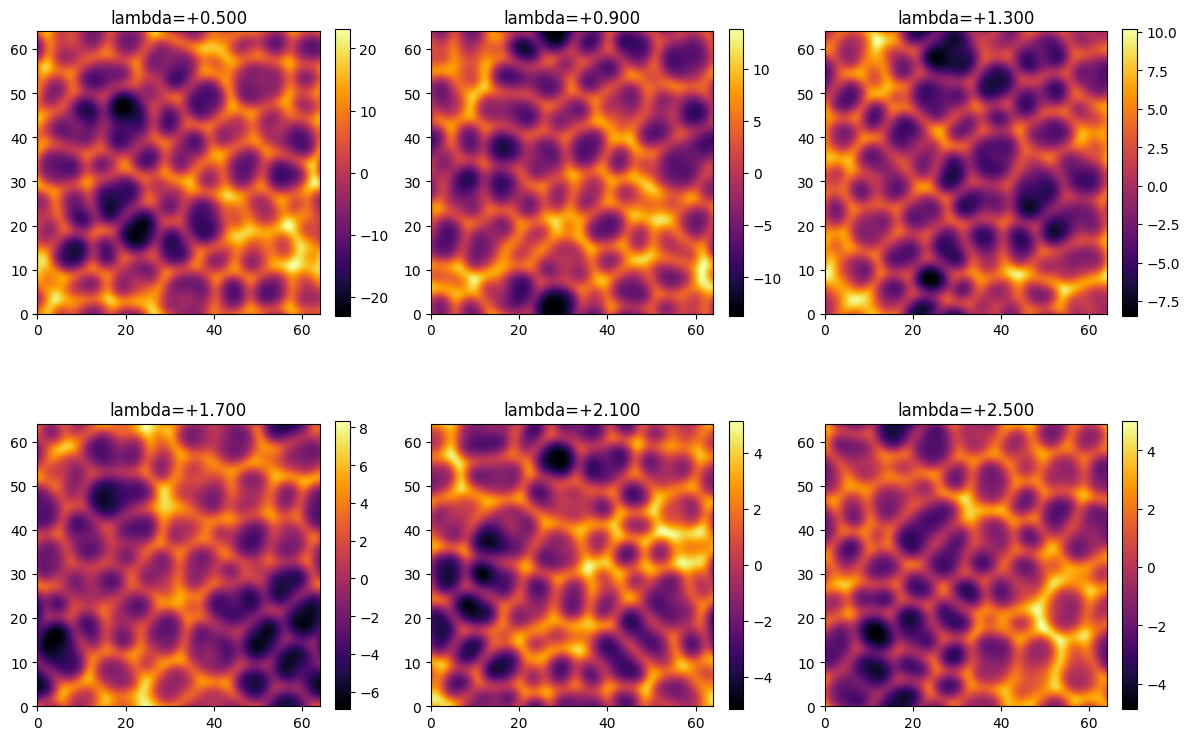

In [6]:
n_snap = min(6, len(fields))
snap_indices = np.linspace(0, len(fields) - 1, n_snap, dtype=int)

cols = 3
rows = int(np.ceil(n_snap / cols))
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 4 * rows))
axes = np.array(axes).reshape(-1)

for ax, idx in zip(axes, snap_indices):
    im = ax.imshow(fields[idx], origin="lower", extent=(0, L, 0, L))
    ax.set_title(f"lambda={lamb_history[idx]:+.3f}")
    fig.colorbar(im, ax=ax, fraction=0.046)

for ax in axes[len(snap_indices):]:
    ax.axis("off")

fig.tight_layout()
plt.show()

### Bifurcation Diagram

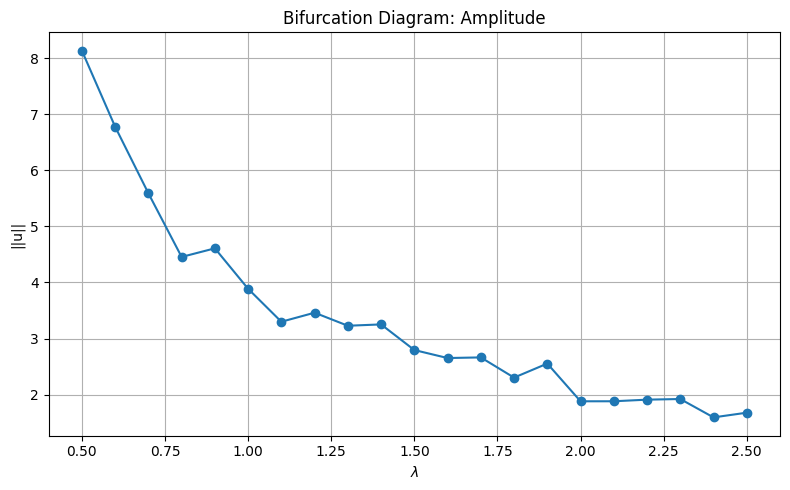

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Norm vs Lambda
ax.plot(lamb_history, norms, "o-", label="L2 Norm")
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel("||u||")
ax.set_title("Bifurcation Diagram: Amplitude")
ax.grid(True)

plt.tight_layout()
plt.show()